In [1]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [2]:
import torch
import numpy as np
from matplotlib import cm
from pilotnet import PilotNet, get_transform
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F

In [3]:
net = PilotNet()
net.load_state_dict(torch.load('../checkpoints/net_epoch_1.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [4]:
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name)

conv1.weight
conv1.bias
conv2.weight
conv2.bias
conv3.weight
conv3.bias
conv4.weight
conv4.bias
conv5.weight
conv5.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias
fc4.weight
fc4.bias
fc5.weight
fc5.bias


In [5]:
net

PilotNet(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=1164, bias=True)
  (fc2): Linear(in_features=1152, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=1, bias=True)
  (dconv1): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (dconv2): ConvTranspose2d(1, 1, kernel_size=(5, 5), stride=(2, 2), bias=False)
)

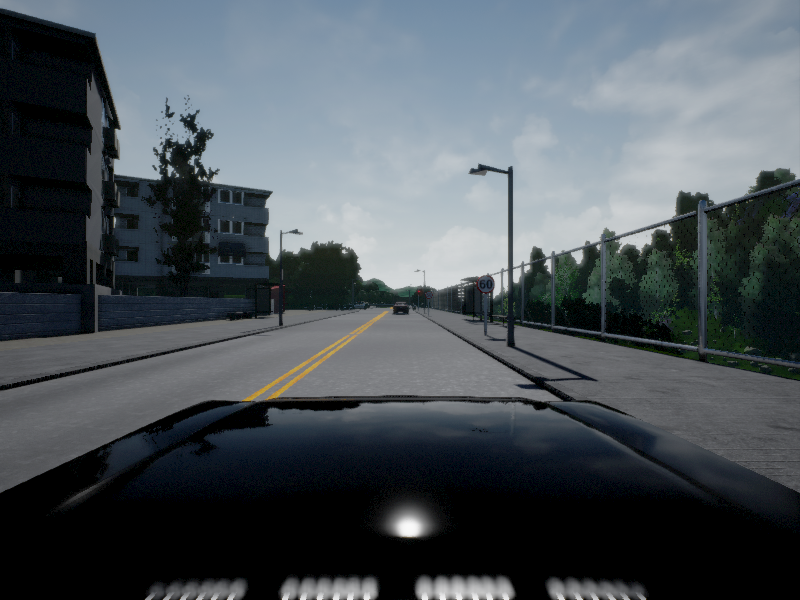

In [6]:
im = Image.open('../data/2020-10-14--09-02-25/train/episode_0003/RGBCenter/000140.png')
im

In [7]:
t = get_transform()

In [8]:
t(im).size()

torch.Size([3, 66, 200])

In [9]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [10]:
net.conv1.register_forward_hook(get_activation('conv1'))


In [11]:
net.visual_mask.register_forward_hook(get_activation('visual_mask'))

AttributeError: 'NoneType' object has no attribute 'register_forward_hook'

In [12]:
activation

{}

In [299]:
output = net(t(im).unsqueeze(0))

In [300]:
conv1_act = activation['conv1']

In [301]:
conv1_act.size()

torch.Size([1, 24, 31, 98])

In [302]:
act = conv1_act.squeeze()

In [20]:
act.size(0)

24

In [114]:
F.relu(act[0])

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.1386, 0.1412, 0.1325],
        [0.0000, 0.0000, 0.0000,  ..., 0.1545, 0.1548, 0.1533],
        [0.0000, 0.0000, 0.0000,  ..., 0.1627, 0.1607, 0.1585],
        ...,
        [0.0118, 0.0137, 0.0102,  ..., 0.0000, 0.1762, 0.3274],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [25]:
mt = transforms.Compose([transforms.CenterCrop((160,320)),transforms.Resize((66,200))])

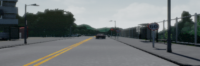

In [26]:
mt(im)

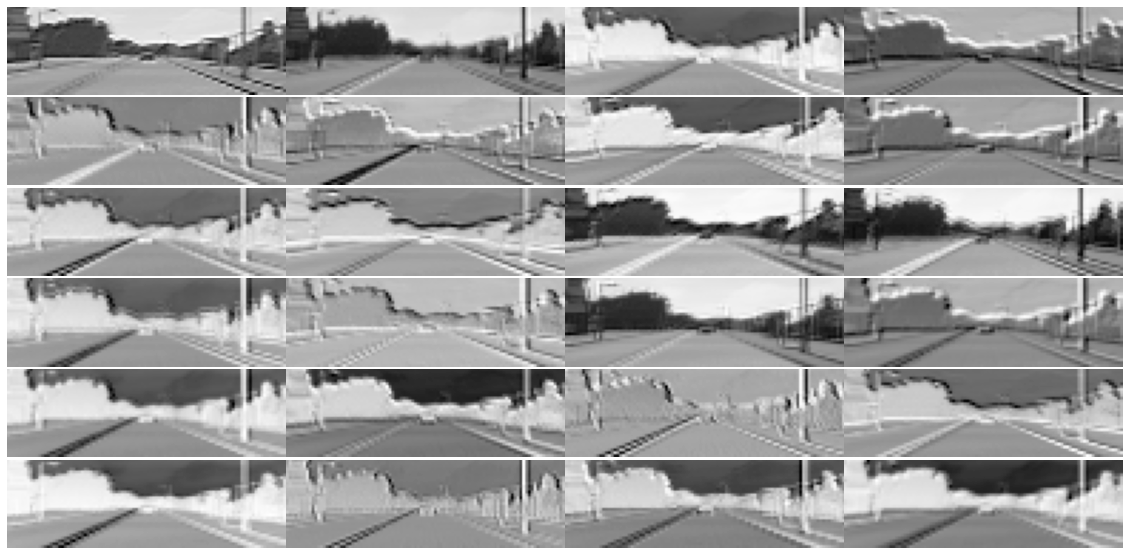

In [21]:
r,c=6,4
fig, axarr = plt.subplots(r,c, sharex='all', sharey='all', figsize=(20, 10))
fig.subplots_adjust(hspace=0.0, wspace=0.0)
for i in range(r):
    for j in range(c):
        axarr[i][j].set_axis_off()
        axarr[i][j].imshow(act[4 * i + j], cmap='Greys')

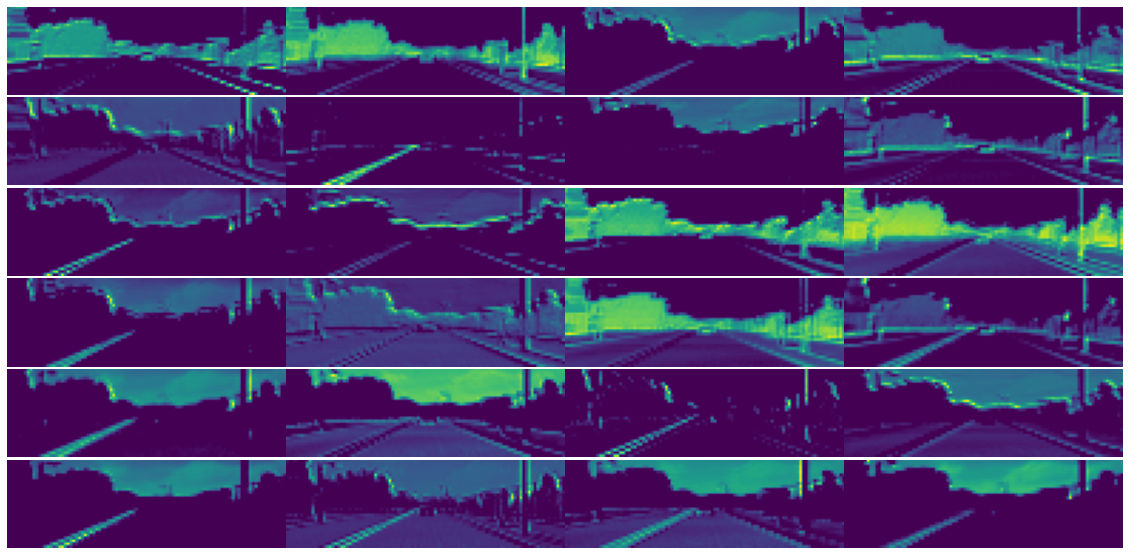

In [22]:
r,c=6,4
fig, axarr = plt.subplots(r,c, sharex='all', sharey='all', figsize=(20, 10))
fig.subplots_adjust(hspace=0.0, wspace=0.0)
for i in range(r):
    for j in range(c):
        axarr[i][j].set_axis_off()
        axarr[i][j].imshow(F.relu(act[4 * i + j]))

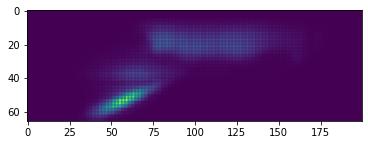

In [39]:
plt.imshow(net.visual_mask.detach().squeeze())

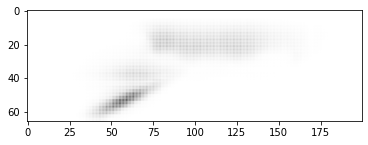

In [61]:
from matplotlib.colors import Normalize
x = plt.imshow(net.visual_mask.detach().squeeze(), norm=Normalize(vmin=0, vmax=1, clip=False), cmap='binary')

In [303]:
mask = net.visual_mask.detach().squeeze().numpy()

In [124]:
np.asarray(pim).shape

(66, 200, 3)

In [133]:
np.expand_dims(mask, 2).shape

(66, 200, 1)

In [159]:
rgba = np.append(np.asarray(pim), np.expand_dims((mask * 255).astype(np.uint8), 2), axis=2)

In [160]:
rgba.shape

(66, 200, 4)

In [149]:
pim = mt(im)

In [157]:
np.asarray(pim.convert('LA')).shape

(66, 200, 2)

In [274]:
mask.max()

0.6384756

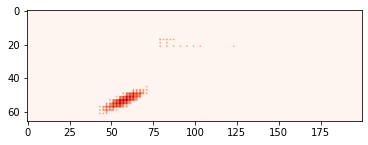

In [330]:
plt.imshow(mask, cmap='Reds')

In [308]:
mask = net.visual_mask.detach().squeeze().numpy().copy()

In [ ]:
net.visual_mask.detach().squeeze().numpy()

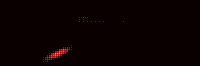

In [312]:
maskim = Image.fromarray(np.uint8(cm.hot(mask)*255))
maskim

In [310]:
idx = mask < 0.2

In [311]:
mask[idx] = 0

In [318]:
# img = Image.open('img.png')
# img = img.convert("RGBA")
datas = maskim.getdata()

newData = []
for item in datas:
#     print(item)
    if item[0] == 10 and item[1] == 0 and item[2] == 0:
        newData.append((255, 255, 255, 0))
    else:
        newData.append(item)

maskim.putdata(newData)


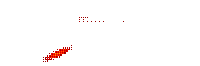

In [319]:
maskim

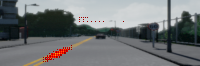

In [327]:
Image.alpha_composite(pim, maskim)

In [256]:
np.array(pim).shape

(66, 200, 4)

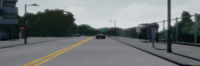

In [278]:
pim.putalpha(255)
pim

In [321]:
np.array(maskim).shape

(66, 200, 4)

In [264]:
pim.paste(maskim, (0,0), maskim)

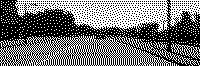

In [326]:
pim.convert('1')

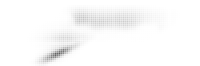

In [283]:
maskim

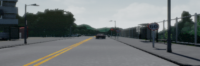

In [277]:
pim = mt(im)
pim

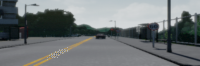

In [293]:
Image.alpha_composite(pim, maskim)

In [79]:
norm_mask = np.ma.getdata(Normalize(vmin=0, vmax=1, clip=True)(mask))

In [81]:
np.ma.getmask(Normalize(vmin=0, vmax=1, clip=True)(mask))

False

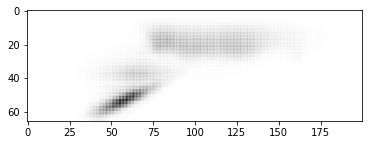

In [82]:
plt.imshow(norm_mask, cmap='binary')

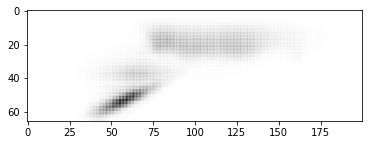

In [96]:
plt.imshow(mask, cmap='binary')

In [92]:
norm_mask.shape

(66, 200)

In [99]:
net.visual_mask.detach().squeeze().numpy()

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.3118600e-07,
        6.6763036e-08, 6.6763036e-08],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.3641593e-08,
        3.1557036e-08, 3.1557036e-08],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.3641593e-08,
        3.1557036e-08, 3.1557036e-08]], dtype=float32)

In [98]:
norm_mask

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.3118600e-07,
        6.6763036e-08, 6.6763036e-08],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.3641593e-08,
        3.1557036e-08, 3.1557036e-08],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.3641593e-08,
        3.1557036e-08, 3.1557036e-08]], dtype=float32)

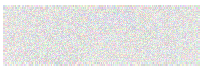

In [95]:
Image.fromarray(mask, 'RGBA')